# A Hierarchical model for rugby prediction

Our goal is to infer a latent parameter for the "strength" of a team based on their scoring intensity.

In [1]:
from io import StringIO

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

gg.theme_set(gg.theme_minimal())

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

## Data

In [2]:
df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]

df_all.head()

,home_team,away_team,home_score,away_score,year,difference,difference_non_abs
0,Wales,Italy,23,15,2014,8,8
1,France,England,26,24,2014,2,2
2,Ireland,Scotland,28,6,2014,22,22
3,Ireland,Wales,26,3,2014,23,23
4,Scotland,England,0,20,2014,20,-20


## Visualization / EDA

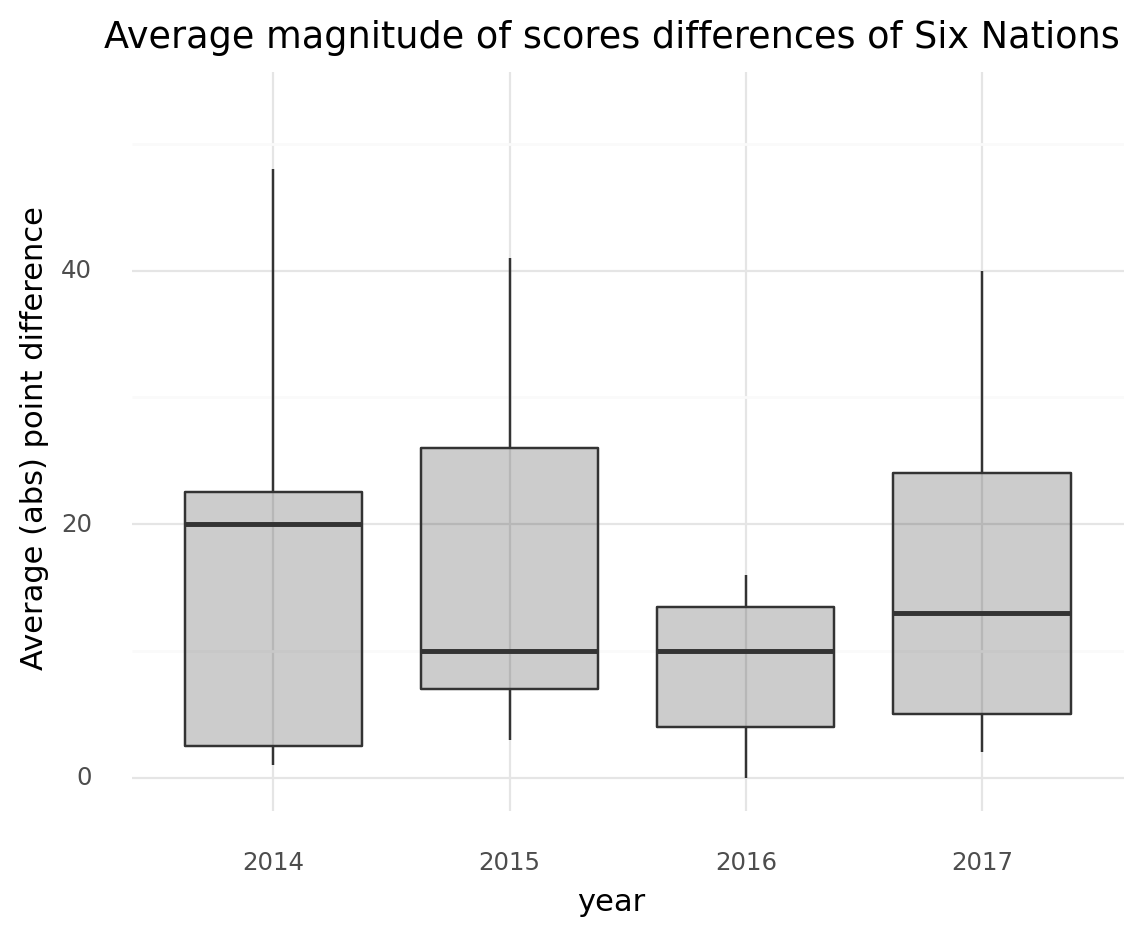

<ggplot: (273029494)>

In [3]:
(
    gg.ggplot(df_all, gg.aes(x="factor(year)", y="difference"))
    + gg.geom_boxplot(fill="black", alpha=0.2, outlier_alpha=0)
    + gg.labs(
        x="year",
        y="Average (abs) point difference",
        title="Average magnitude of scores differences of Six Nations",
    )
)

In [4]:
df_all.head()

,home_team,away_team,home_score,away_score,year,difference,difference_non_abs
0,Wales,Italy,23,15,2014,8,8
1,France,England,26,24,2014,2,2
2,Ireland,Scotland,28,6,2014,22,22
3,Ireland,Wales,26,3,2014,23,23
4,Scotland,England,0,20,2014,20,-20


We can see that Italy and England have poor away-form.

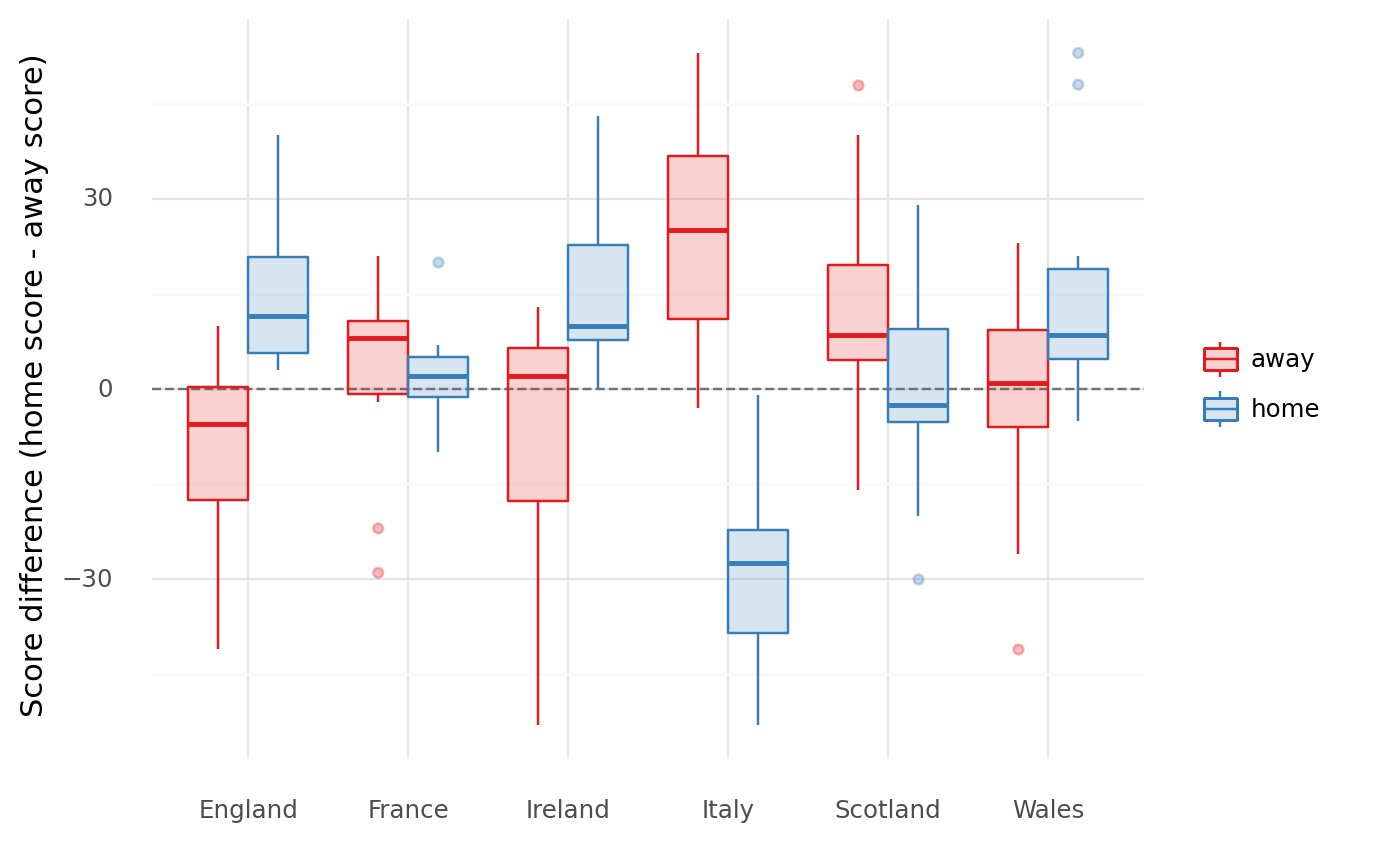

<ggplot: (342032255)>

In [5]:
plot_data = (
    df_all[["difference_non_abs", "home_team", "away_team", "year"]]
    .melt(id_vars=["difference_non_abs", "year"])
    .assign(variable=lambda d: [s.replace("_team", "") for s in d.variable])
)

(
    gg.ggplot(plot_data, gg.aes(x="value", y="difference_non_abs"))
    + gg.geom_hline(yintercept=0, linetype="--", alpha=0.5, color="black")
    + gg.geom_boxplot(
        gg.aes(color="variable", fill="variable"),
        position="dodge",
        alpha=0.2,
        outlier_alpha=0.3,
    )
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.theme(legend_title=gg.element_blank())
    + gg.labs(x=None, y="Score difference (home score - away score)")
)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


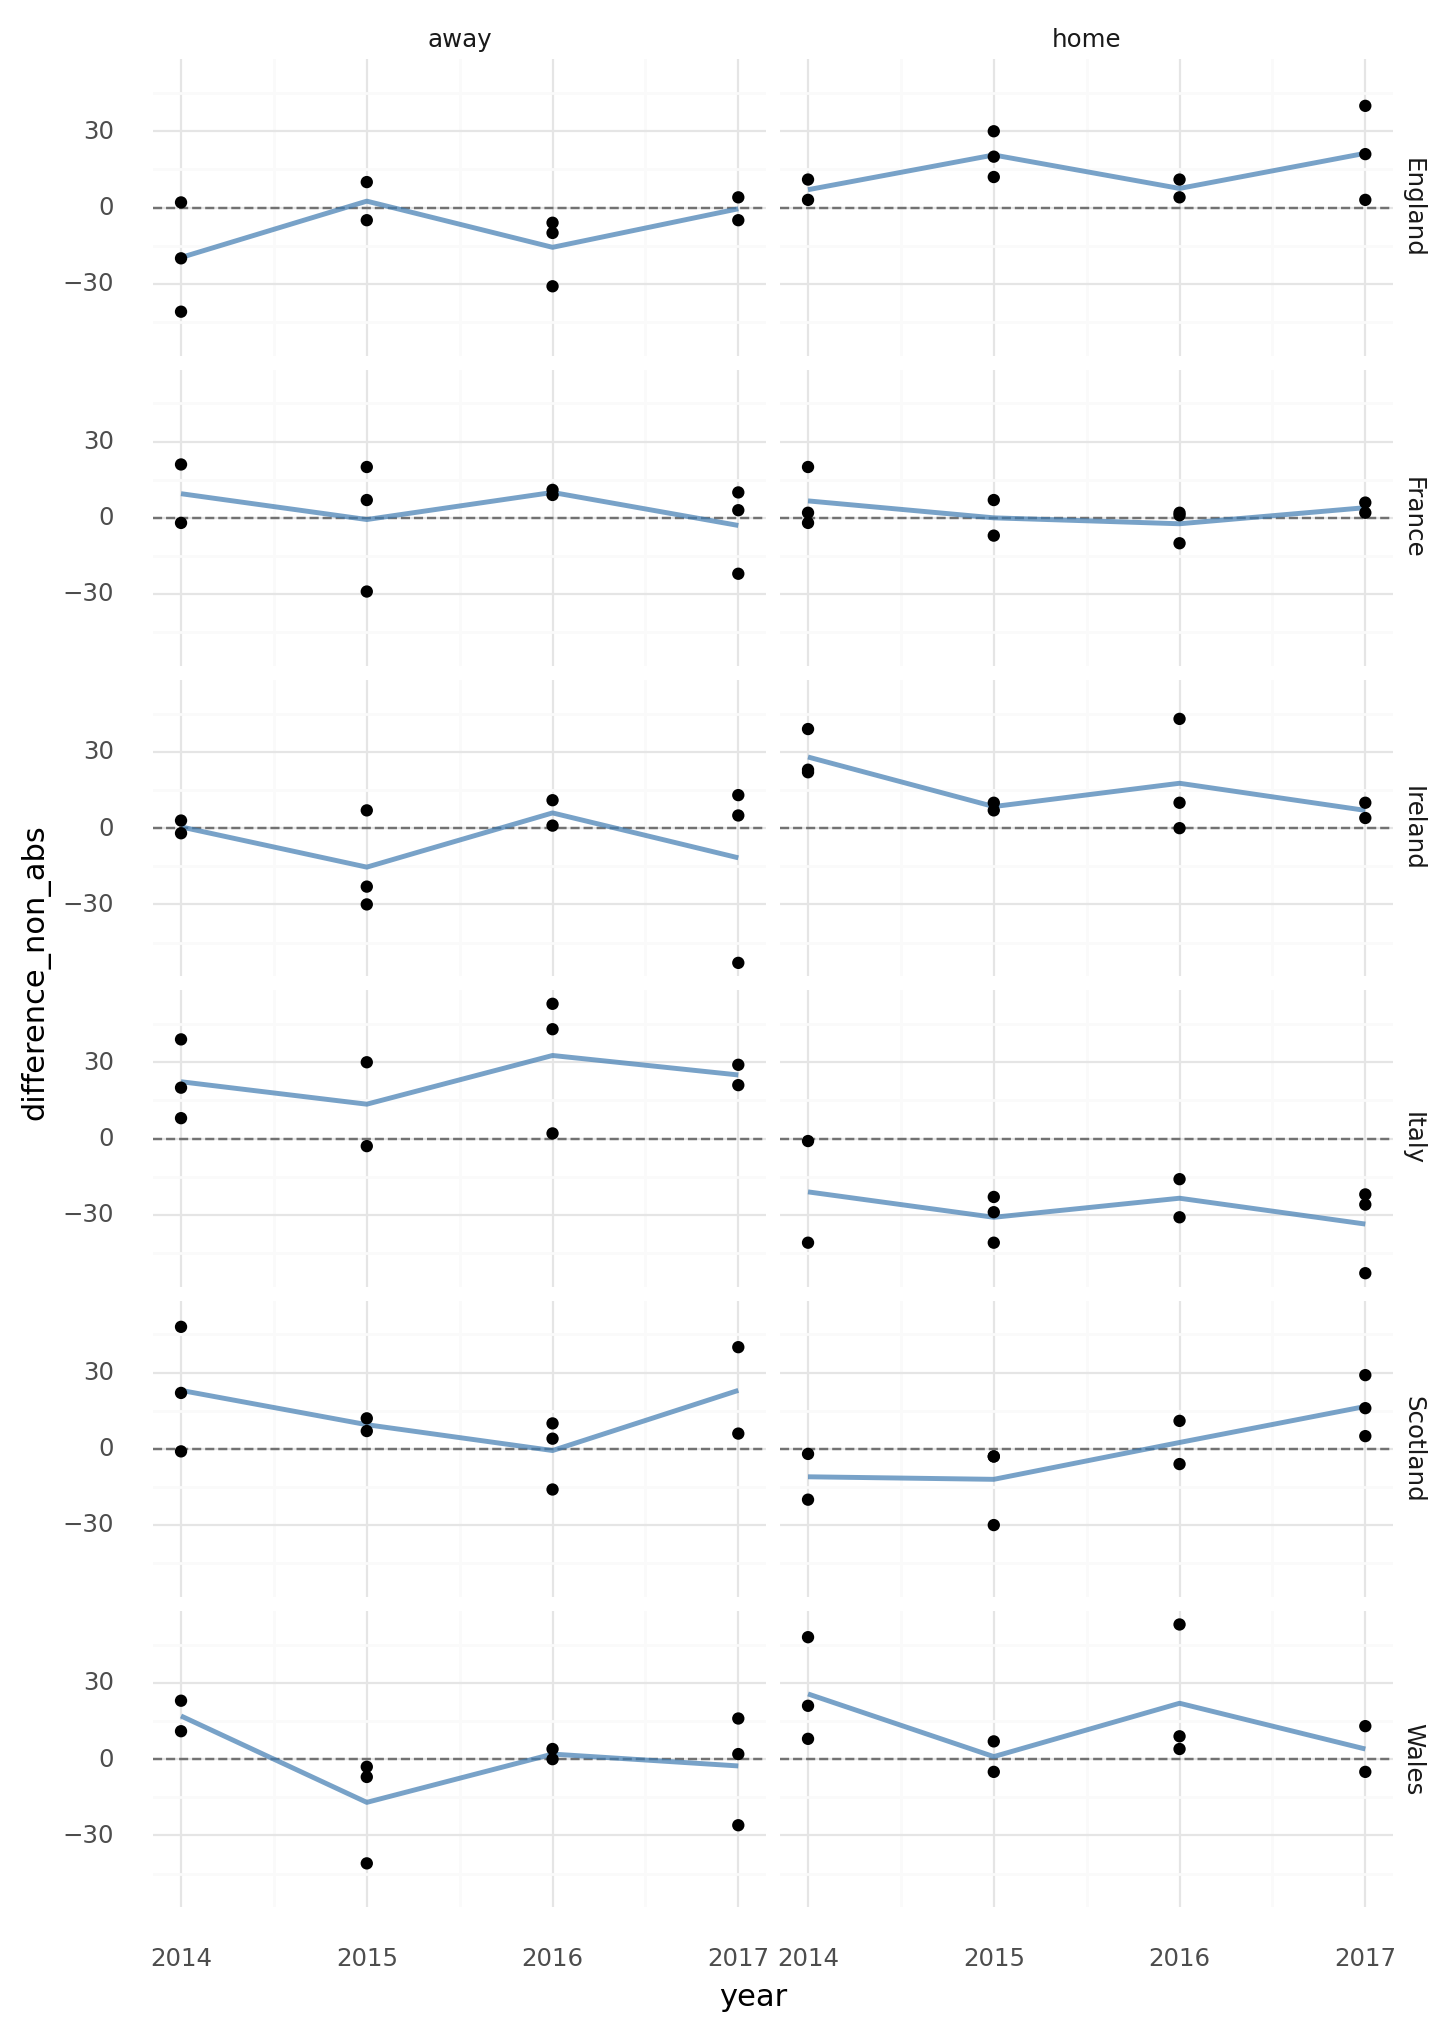

<ggplot: (342163505)>

In [6]:
plot_data_summary = (
    plot_data.groupby(["year", "variable", "value"]).mean().reset_index(drop=False)
)

(
    gg.ggplot(plot_data, gg.aes(x="year", y="difference_non_abs"))
    + gg.facet_grid("value ~ variable")
    + gg.geom_hline(yintercept=0, linetype="--", color="black", alpha=0.5)
    + gg.geom_line(
        group="a", data=plot_data_summary, alpha=0.7, color="#3F7BB1", size=1
    )
    + gg.geom_point()
    + gg.theme(figure_size=(8, 12))
)

## Model

There are 6 teams ($T=6$) that play each other once in a season.
The number of points scored by the home and away team in the $g$-th game of the season (15 games in total) as $y_{g1}$ and $y_{g2}$.
The vector of observed counts $y = (y_{g1}, y_{g2})$ is modelled as an independent Poisson: $\mathbb{y}_{gi} | \theta_{gj} \sim \text{Poisson}(\theta_{gj})$ where the $\theta$ parameters represents the scoring intensity in the $g$-th game for the team playing at home ($j=1$) or away ($j=2$).

The model is shown below constructed of two equations, one for the number of points by the home team and one for the away team.
The only differences is that the home team has the $home$ covariate to include for the "home-field advantage".

$$
\begin{align}
\log \theta_{g1} &= home + att_{h(g)} + def_{a(g)} \\
\log \theta_{g2} &= att_{a(g)} + def_{h(g)} \\
\end{align}
$$

The $home$ covariate will be constant through time and for all teams.
The score for a team is determined by the "attack" ($att$) and "defensibility" ($def$) of the two teams.

The attack and defensibility for each team $t$ come from common distributions.

$$
\begin{align}
att_t &\sim \mathcal{N}(\mu_{att}, \tau_{att}) \\
def_t &\sim \mathcal{N}(\mu_{def}, \tau_{def}) \\
\end{align}
$$

To help with sampling, the actual model will be reparamaterized using "non-centered parameterization." Here is a good link for learning about this technique: ["Why hierarchical models are awesome, tricky, and Bayesian"](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/#Reparameterization).

In [7]:
df = df_all[["home_team", "away_team", "home_score", "away_score"]].reset_index(
    drop=True
)

for col in ["home_team", "away_team"]:
    df[col] = pd.Categorical(df[col].values, ordered=True)

home_team = df.home_team.cat.codes.to_numpy()
away_team = df.away_team.cat.codes.to_numpy()

num_teams = len(np.unique(home_team))
num_games = df.shape[0]

In [8]:
with pm.Model() as model:

    # Global model parameters.
    home = pm.Normal("home", 1, 10)
    τ_att = pm.HalfStudentT("τ_att", nu=3, sigma=2.5)
    τ_def = pm.HalfStudentT("τ_def", nu=3, sigma=2.5)
    α = pm.Normal("α", 0, 5)  # shared intercept

    # Team-specific model parameters.
    att_star_g = pm.Normal("att_star_g", 0, τ_att, shape=num_teams)
    def_star_g = pm.Normal("def_star_g", 0, τ_def, shape=num_teams)

    att_g = pm.Deterministic("att_g", att_star_g - tt.mean(att_star_g))
    def_g = pm.Deterministic("def_g", def_star_g - tt.mean(def_star_g))
    θ_home = tt.exp(α + home + att_g[home_team] + def_g[away_team])
    θ_away = tt.exp(α + att_g[away_team] + def_g[home_team])

    # Likelihood of observed data.
    home_points = pm.Poisson("home_points", mu=θ_home, observed=df.home_score)
    away_points = pm.Poisson("away_points", mu=θ_away, observed=df.away_score)

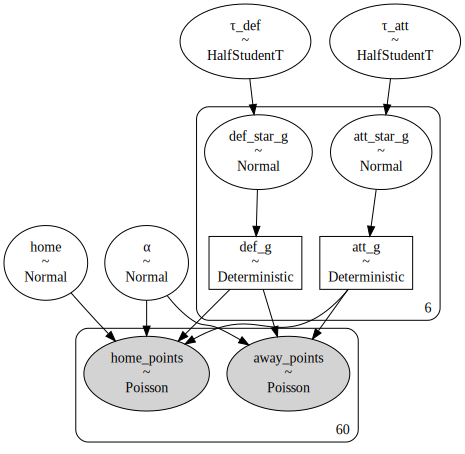

In [9]:
pm.model_to_graphviz(model)

In [10]:
with model:
    trace = pm.sample(1000, tune=2000, chains=3, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [def_star_g, att_star_g, α, τ_def, τ_att, home]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 53 seconds.


In [11]:
az_model = az.from_pymc3(trace=trace, model=model)

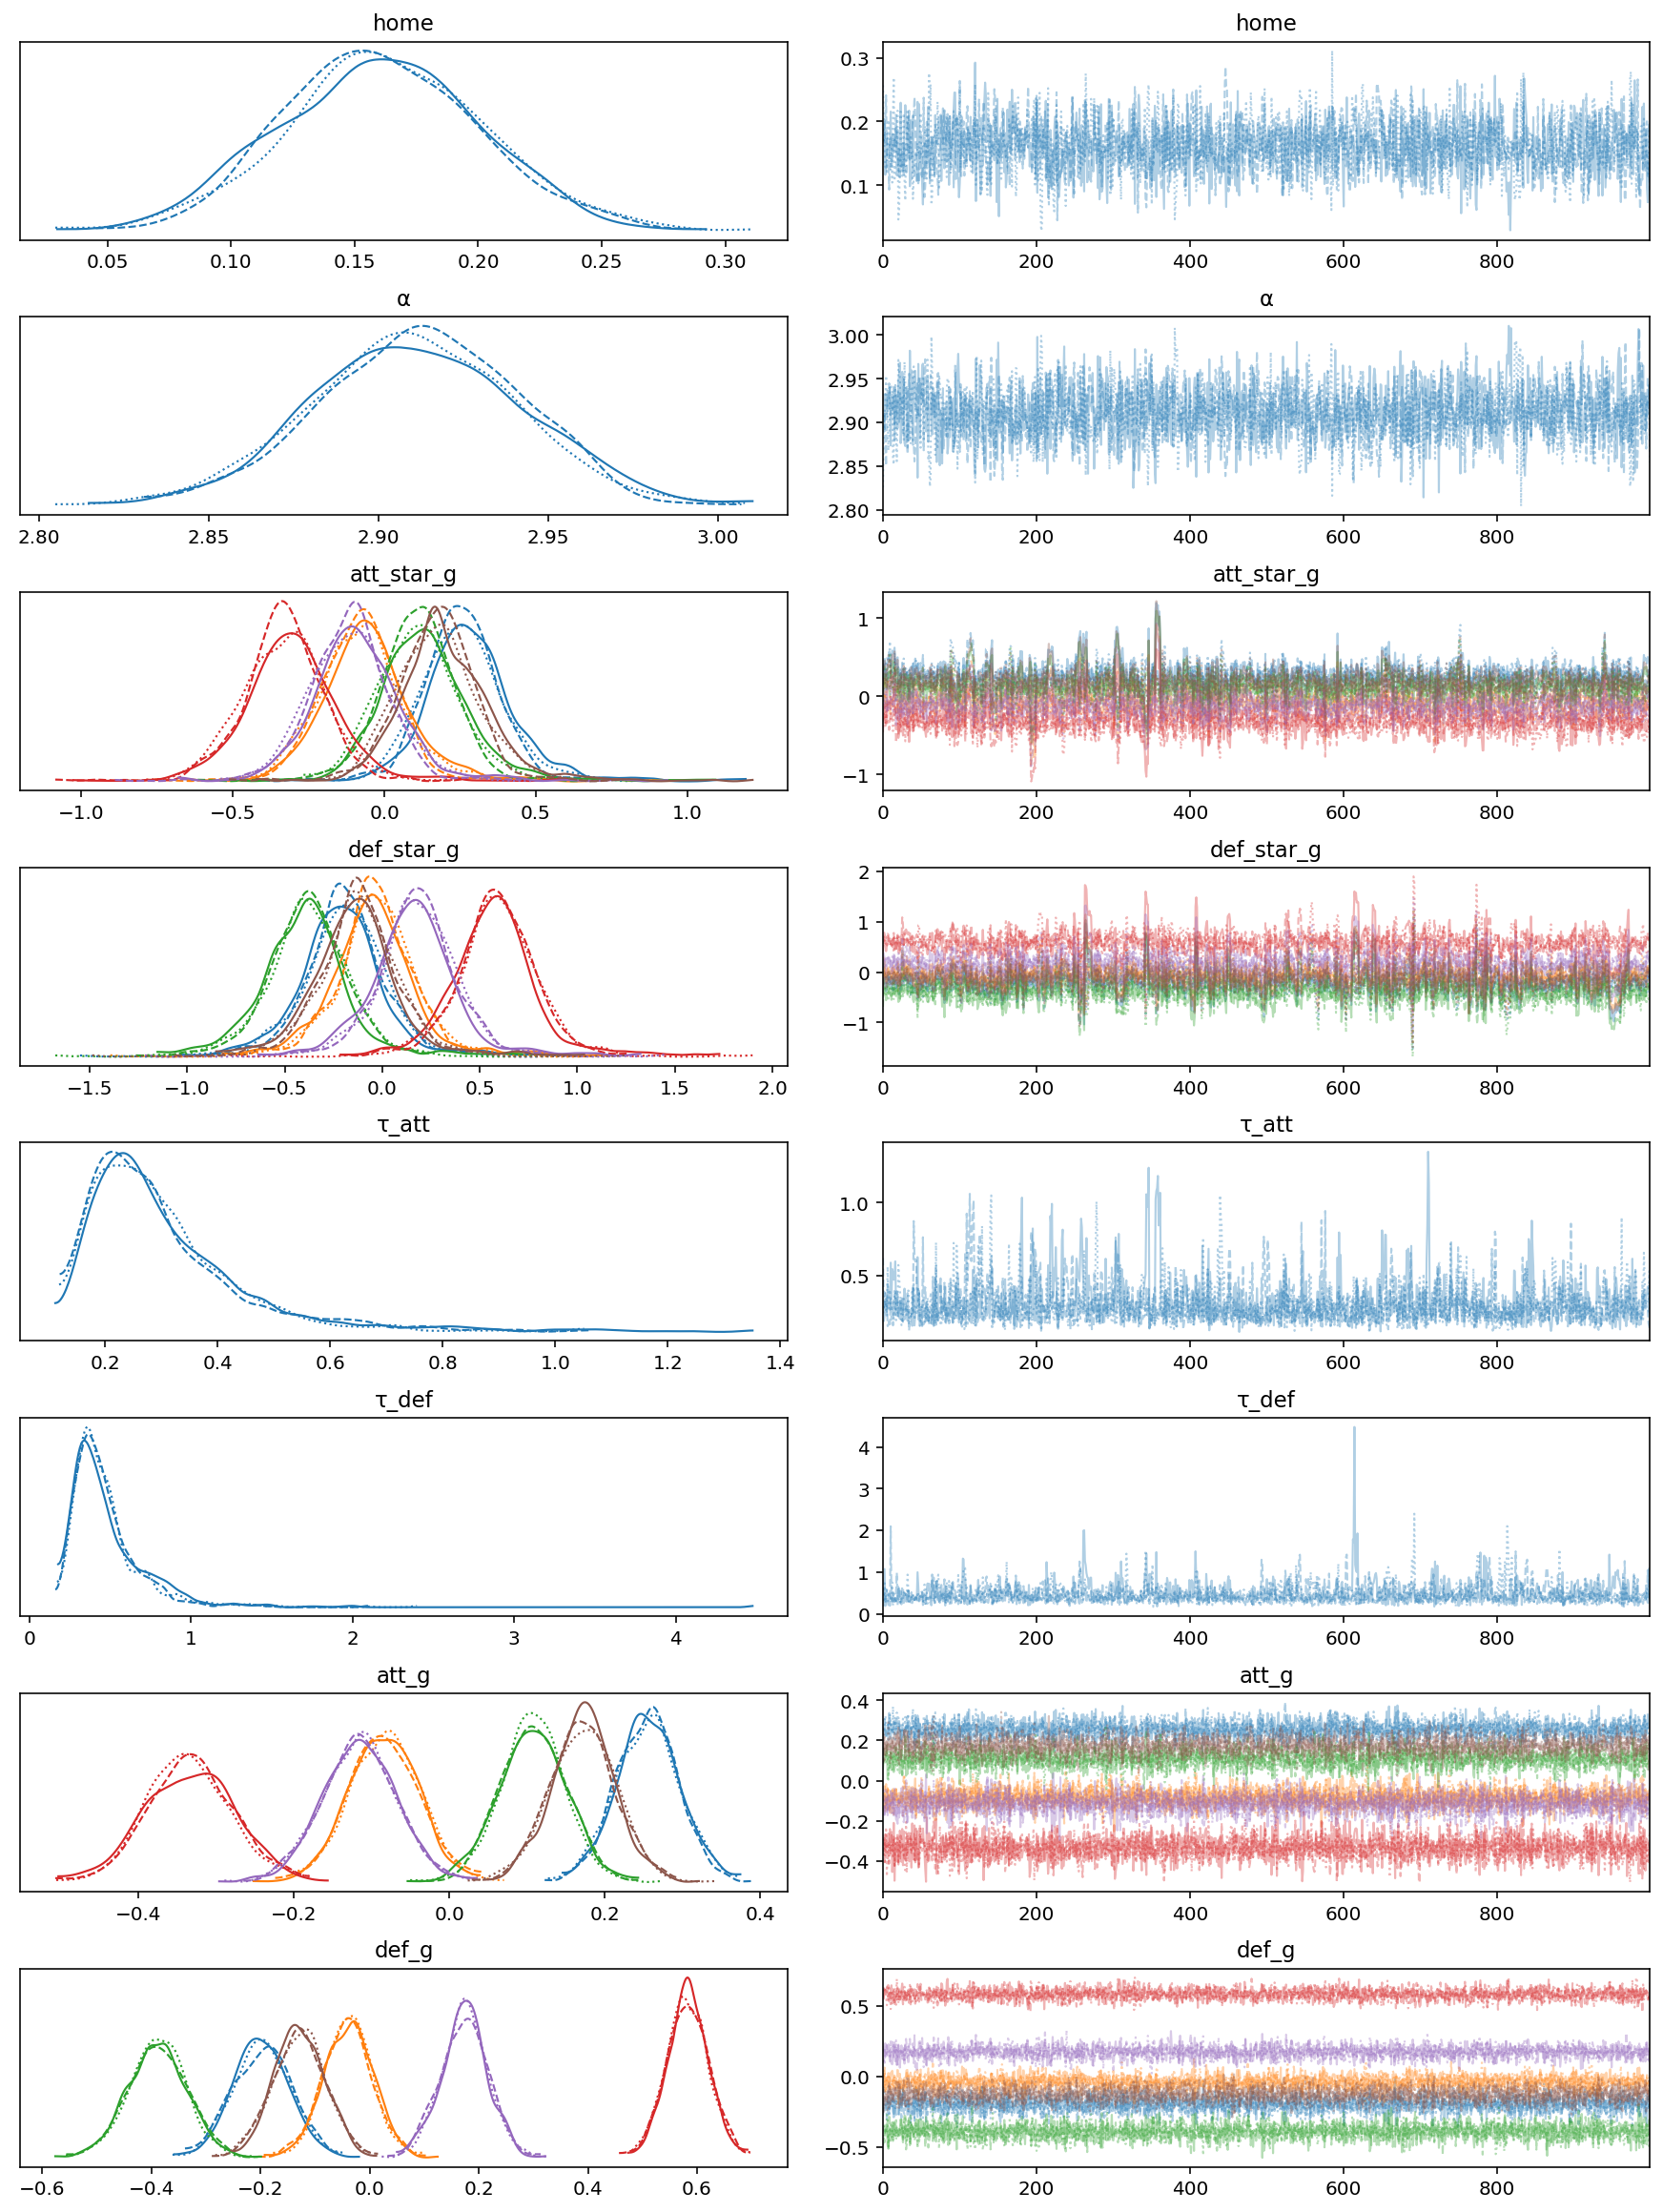

In [12]:
az.plot_trace(az_model)
plt.show()

As in an good statistical workflow, let us check some evaluation metrics to ensure the NUTS sampler converged.

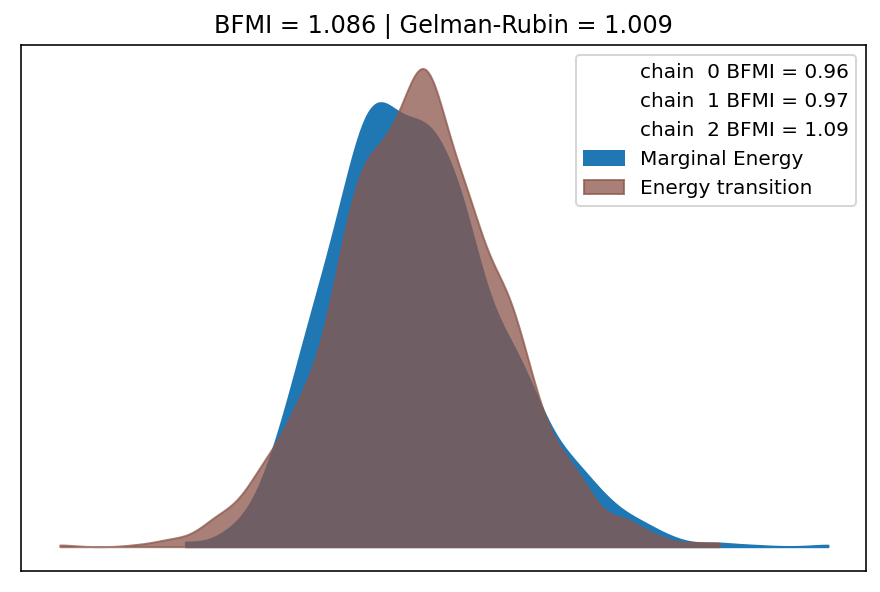

In [13]:
bfmi = np.max(az.bfmi(az_model))
max_gr = np.max(list(np.max(gr_stats) for gr_stats in az.rhat(az_model).values()))

az.plot_energy(az_model, figsize=(6, 4)).set_title(
    f"BFMI = {bfmi:.3f} | Gelman-Rubin = {max_gr:.3f}"
)
plt.show()

## Results